# Radial Velocity Correct 

Correct the radial velocity of the object by shifting the spectrum until it best matches a templete spectrum that is at rest / has already been radial velocity corrected.


Note: Radial velocity correction should typically be done after continuum normalization 

In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np 
import os 
import sys
from os import listdir
import shutil

from astropy.io import ascii
from astropy.io import fits
from astropy.table import Table
from astropy import units as u

# ----------------- Import the other files of functions
module_path = os.path.abspath(os.path.join('../ASAP'))
if module_path not in sys.path:
    sys.path.append(module_path)

import asap_lib.moog_funcs as mf
import asap_lib.auto_atmosphere as aa
import asap_lib.calc_abunds as calc_abunds
import asap_lib.line_list_utils as llu
import asap_lib.spectra as sa
import asap_lib.conversion_utils as cu


**Read In Data**

In [18]:
# -----------------Spectrum to radial velocity correct
spec = 'HD122563ESO.bin' 
spec_path = '../Data/GHOSTData/'

# ----------------- Spectrum that has already been radial velocity corrected / is at rest 
template_spec = 'HD122563.fits' 
template_path = '../Data/HD_fits/'


In [19]:
# ----------------- Note: the spectrum  must be on a constant / linear wavelength grid !!!
# Uncomment the following two lines if need be
wave,flux,err = sa.read_spec(spec_path + spec, ftype='bin')
sa.interp_2_constant_dwgrid( wave, flux, err, saveName=spec_path + spec ) # , 

In [20]:
wave,flux,err = sa.read_spec(spec_path + spec, ftype='bin')

In [21]:
np.diff(wave)

0.012490719733250444
0.012490719733705191
0.012490719733250444
0.012490719733250444
0.012490719733705191
0.012490719733250444
0.012490719733250444
0.012490719733250444
0.012490719733705191
...
0.02583160550057073


## Radial Velocity Correct

On first pass, I'll usually use:

* elems = ['Ha', 'Hb', 'Mg', 'Na']
* manual_rv = None
* save_out_spec = False
* plot_synth = False
* plot_obs = False
* plot_regions = True
* plot_shift = False
* plot_corr = True
* print_spec_info = False
* print_rv_info = True
* save_rv_info = False
* plot_corr_spec_info = False
* save_plot = False
* pause = False

to make sure the windows I chose are okay and that the initail RV's are all looking good. I'll remove bad windows that gave wonky RV's. I don't save anything at this time as I might make changes later.

If everything looks fine, then I'll re-run the cell with:
* elems = *whatever I decided is good*
* manual_rv = None
* save_out_spec = True
* plot_synth = False
* plot_obs = False
* plot_regions = False
* plot_shift = False
* plot_corr = True
* print_spec_info = False
* print_rv_info = True
* save_rv_info = True
* plot_corr_spec_info = False
* save_plot = False
* pause = False

If some regions are bad for some stars and good for others, you may need to run your stars in little batches, varying which windows and RV's you use.

You also might get an error saying something like "ValueError: cannot reshape array of size 0 into shape (0,newaxis)". This usually means the element window you are looking at is outside of the spectral coverage of your template spectrum. plot_synth = True can help identify this.

In [13]:
# ---- Save path and name
saveDir = spec_path 
saveName = saveDir + spec[:-4] + '.txt'

<IPython.core.display.Javascript object>


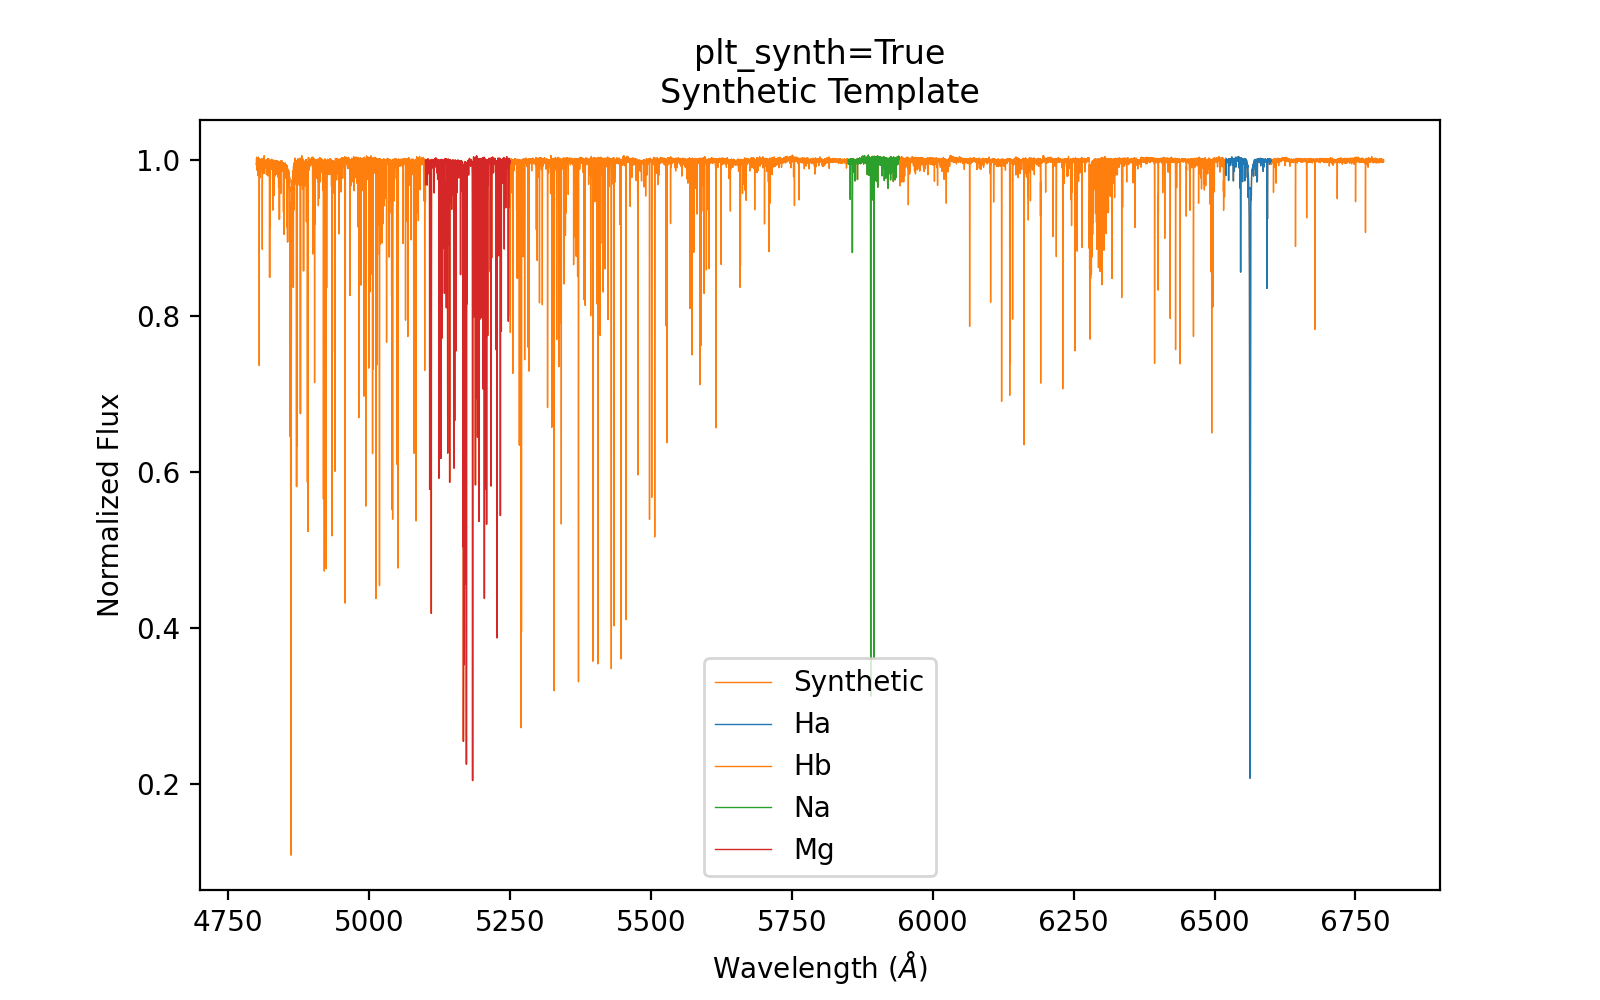


Correcting  HD122563ESO.bin


<IPython.core.display.Javascript object>


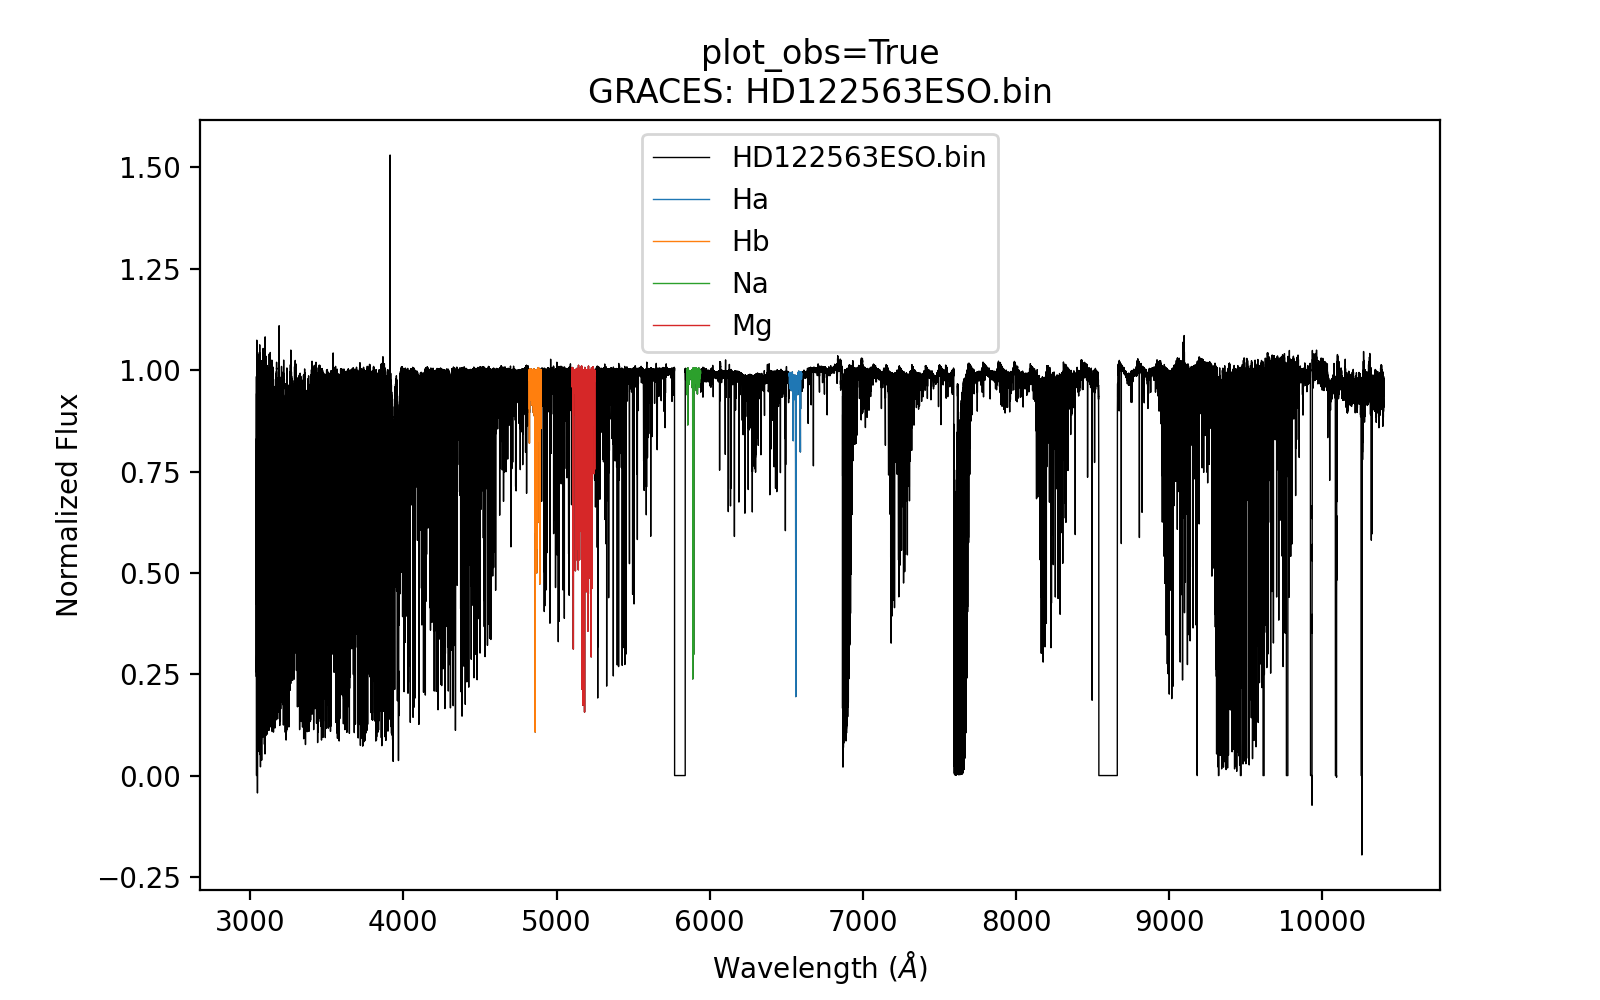

<IPython.core.display.Javascript object>


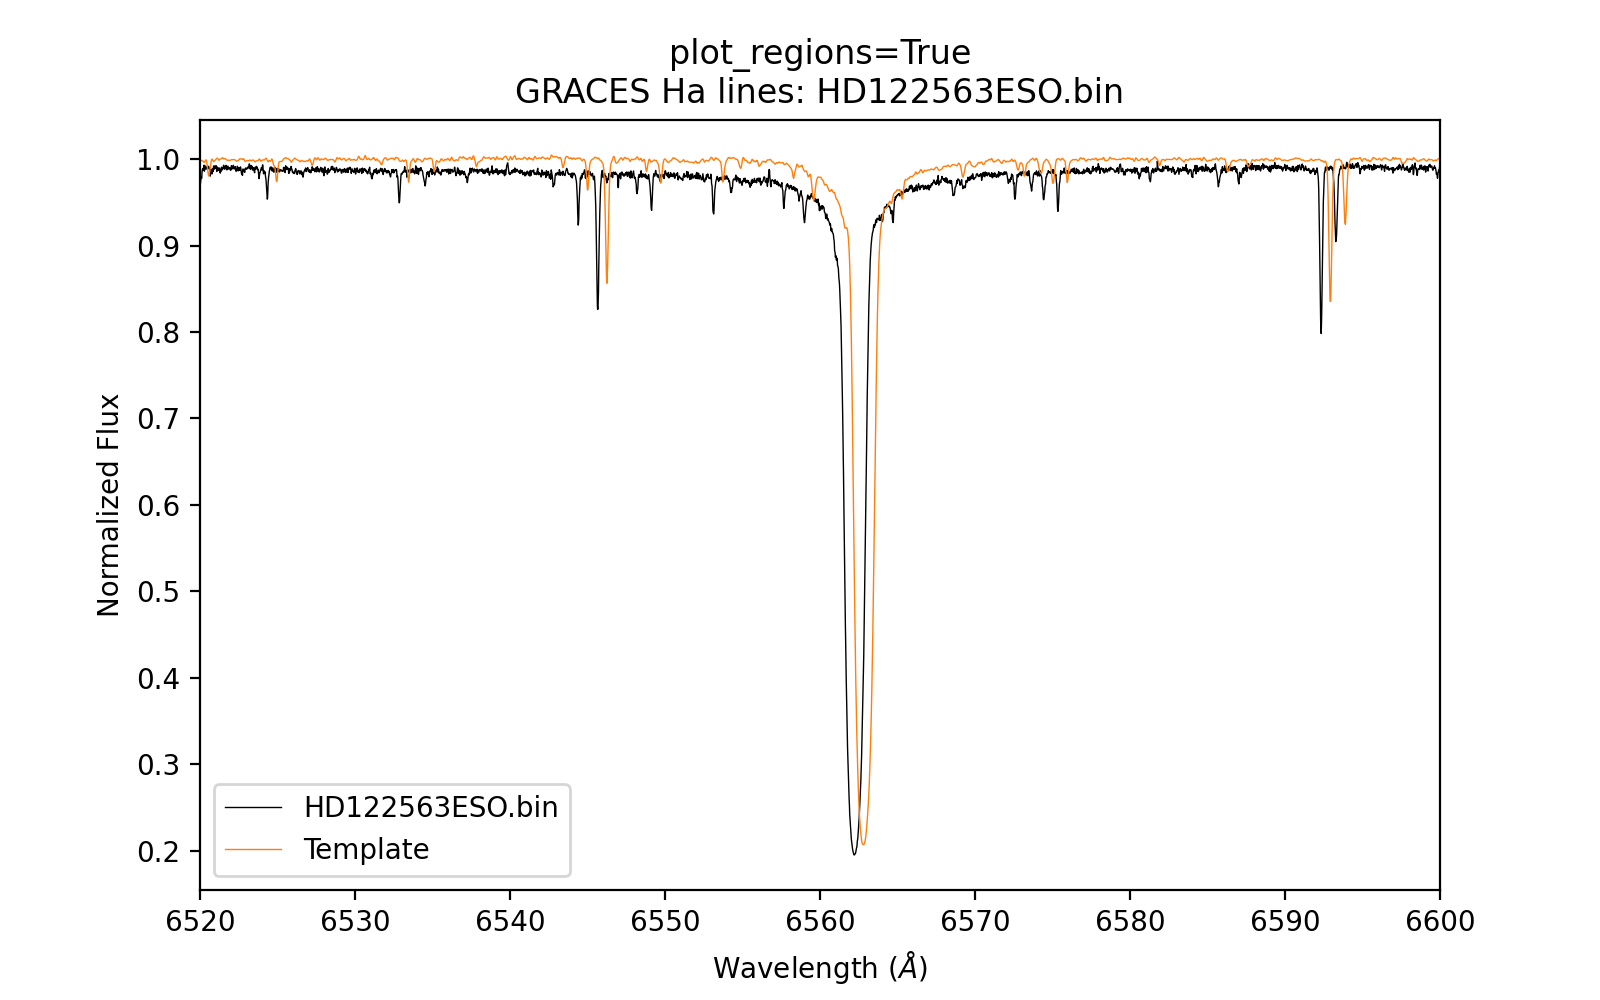

<IPython.core.display.Javascript object>


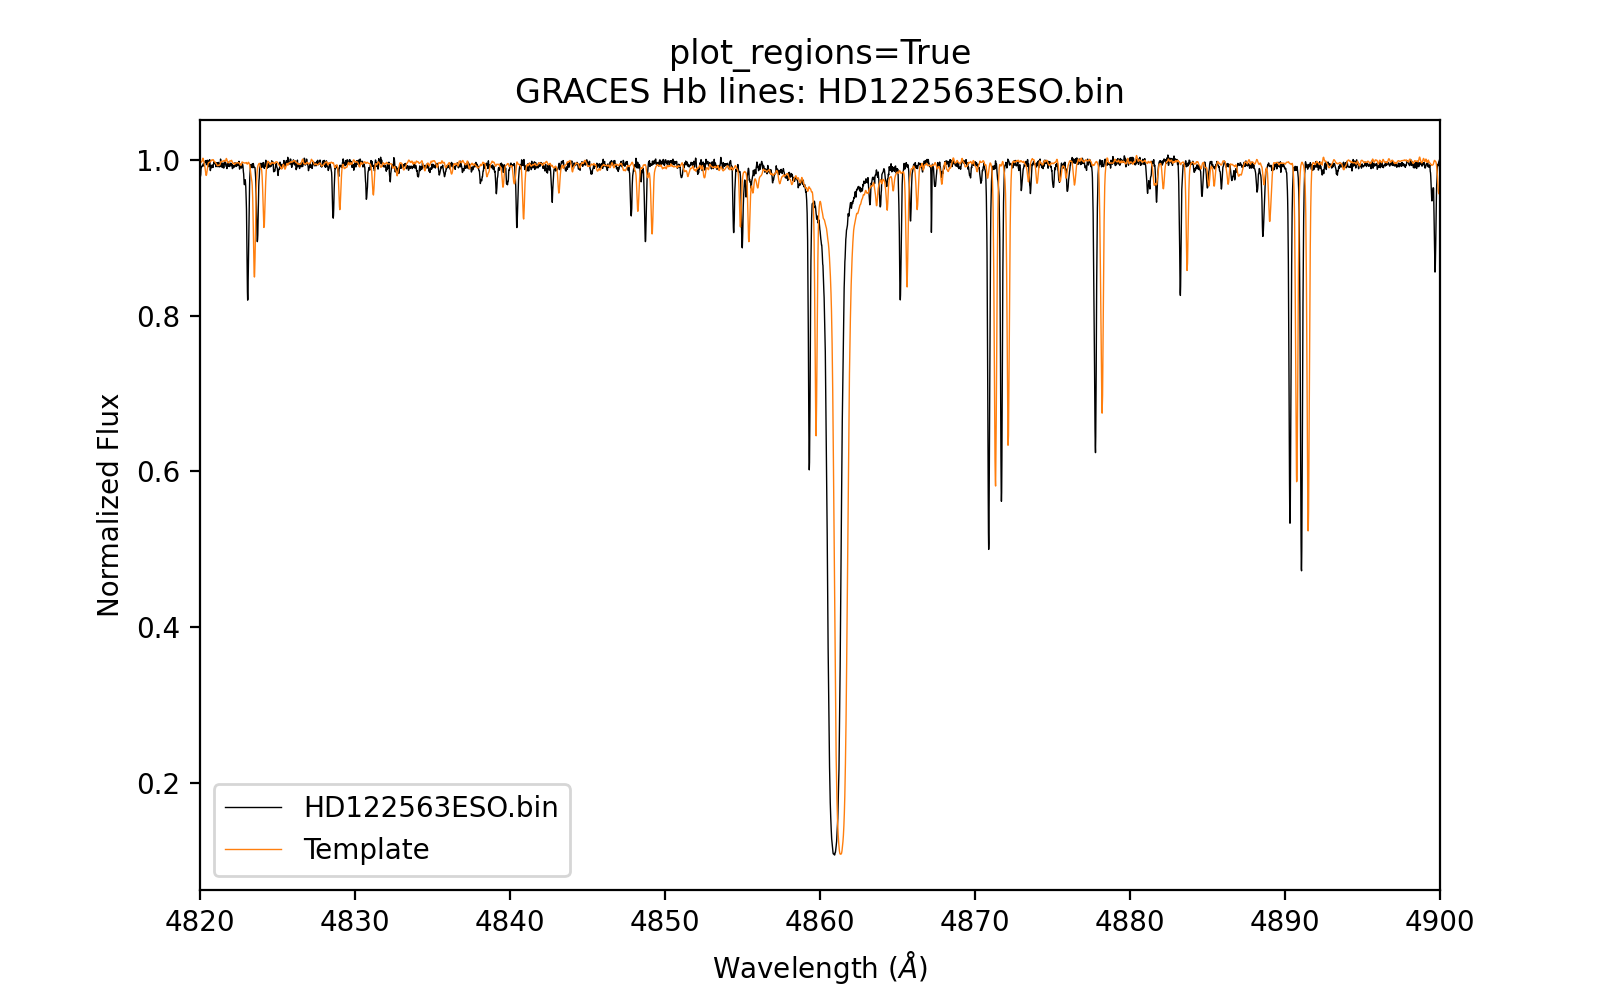

<IPython.core.display.Javascript object>


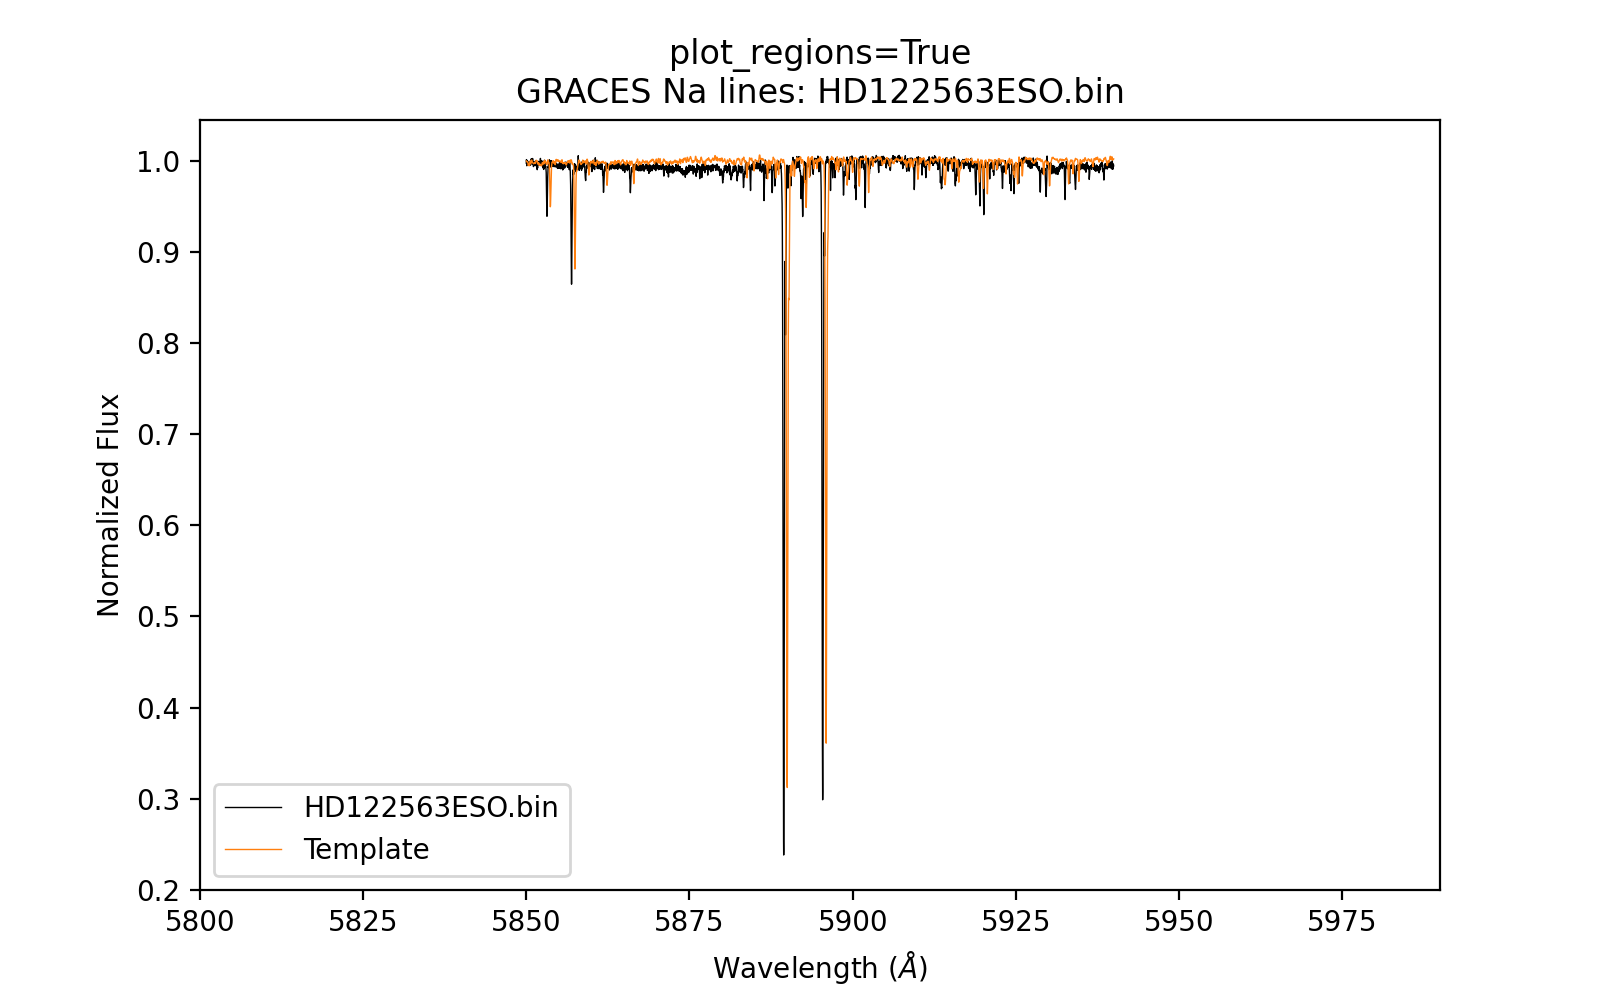

<IPython.core.display.Javascript object>


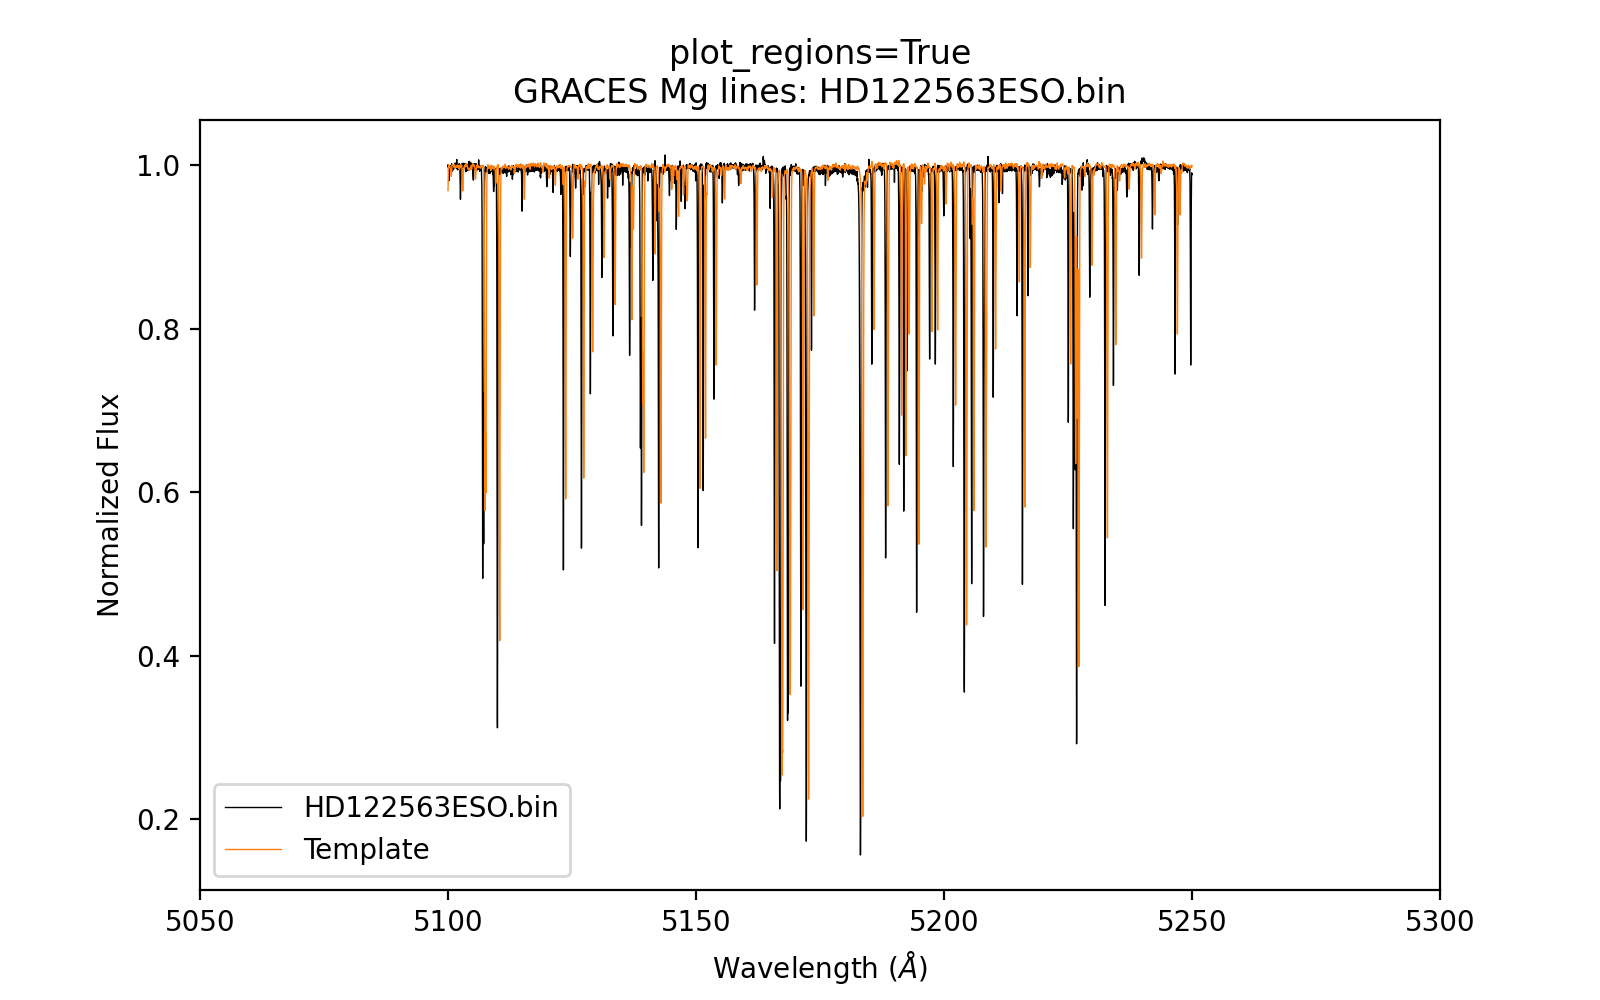

6560.003799977381


<IPython.core.display.Javascript object>


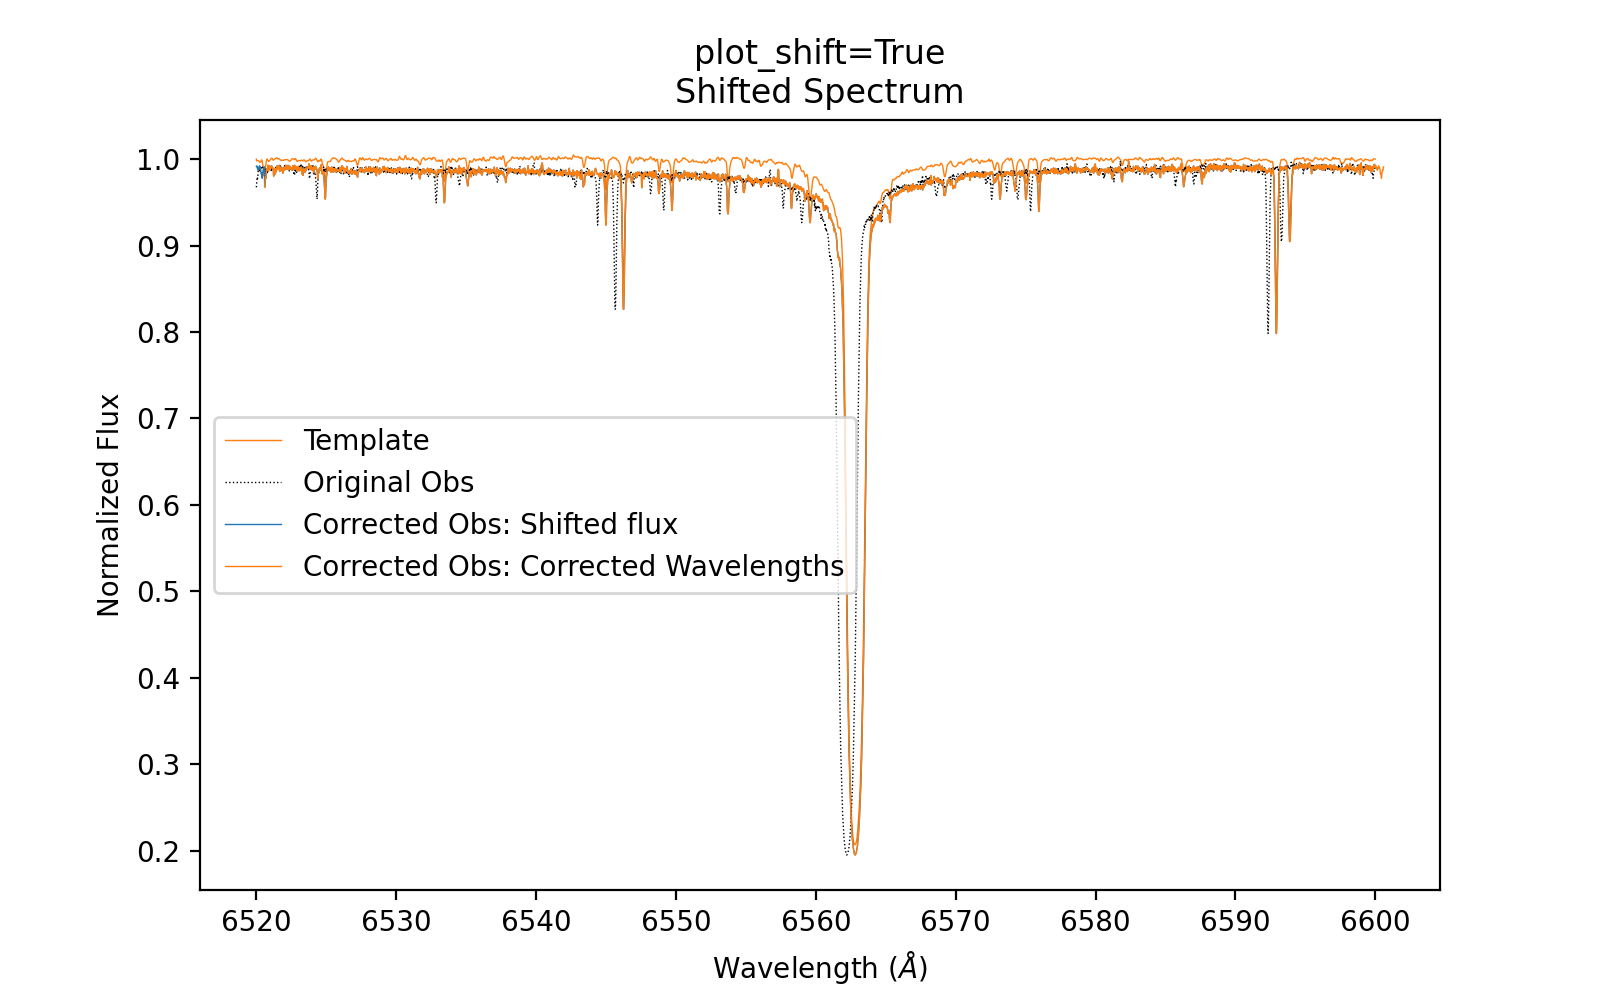

4859.995299975081


<IPython.core.display.Javascript object>


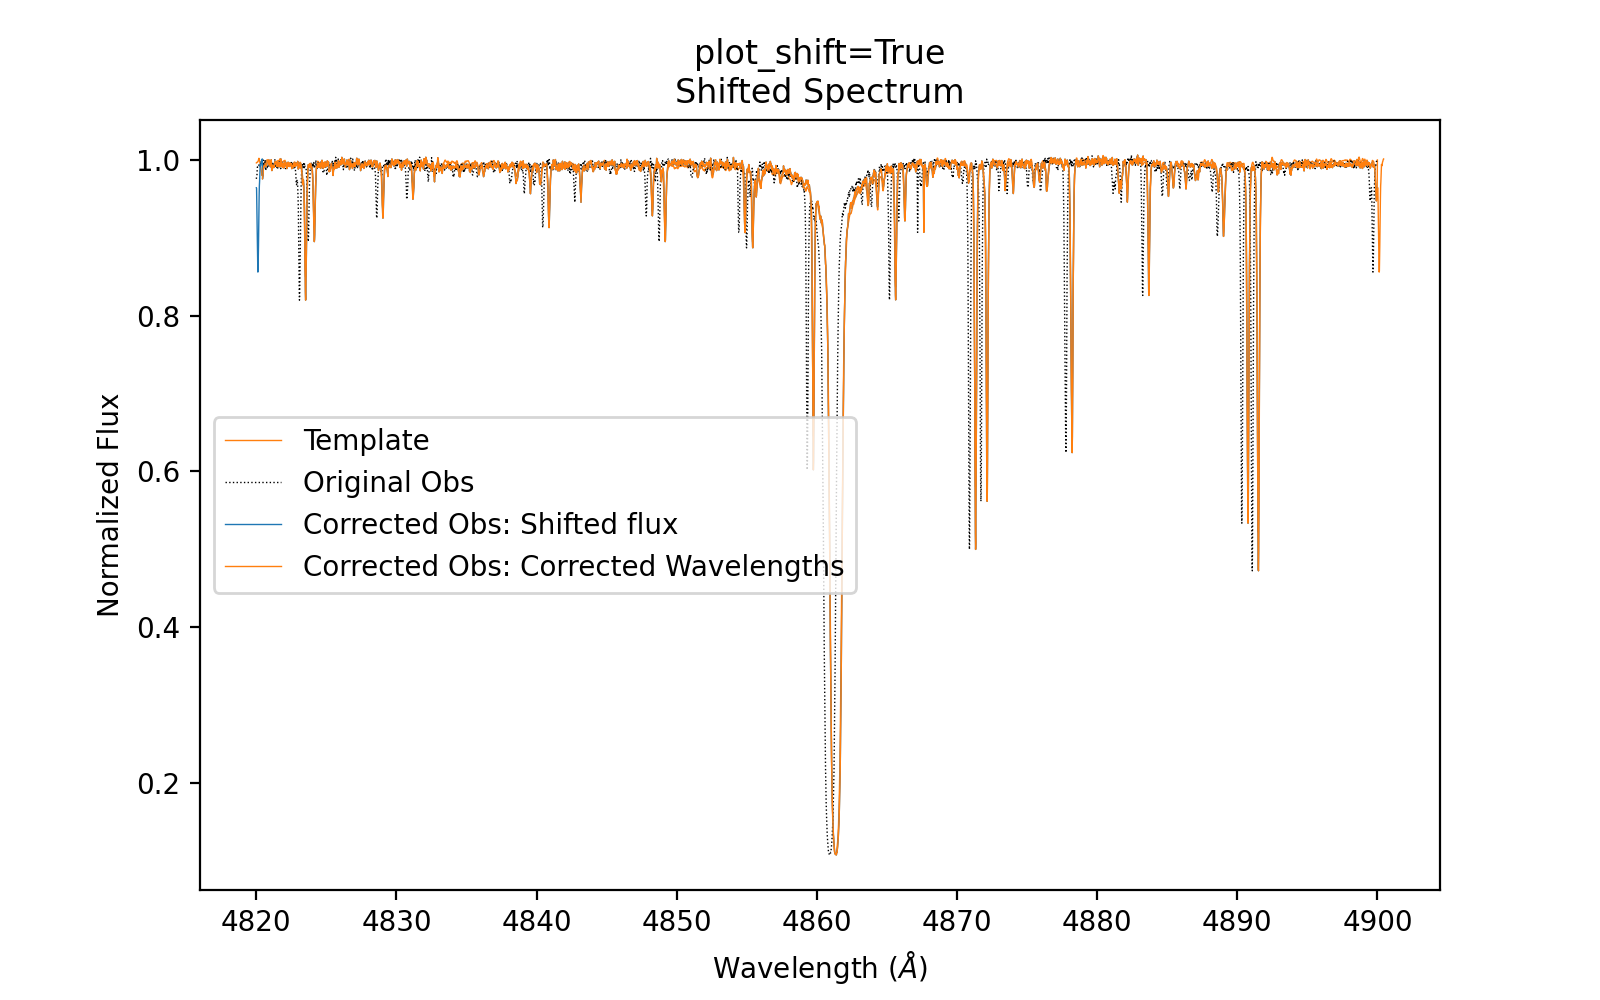

5895.000474976481


<IPython.core.display.Javascript object>


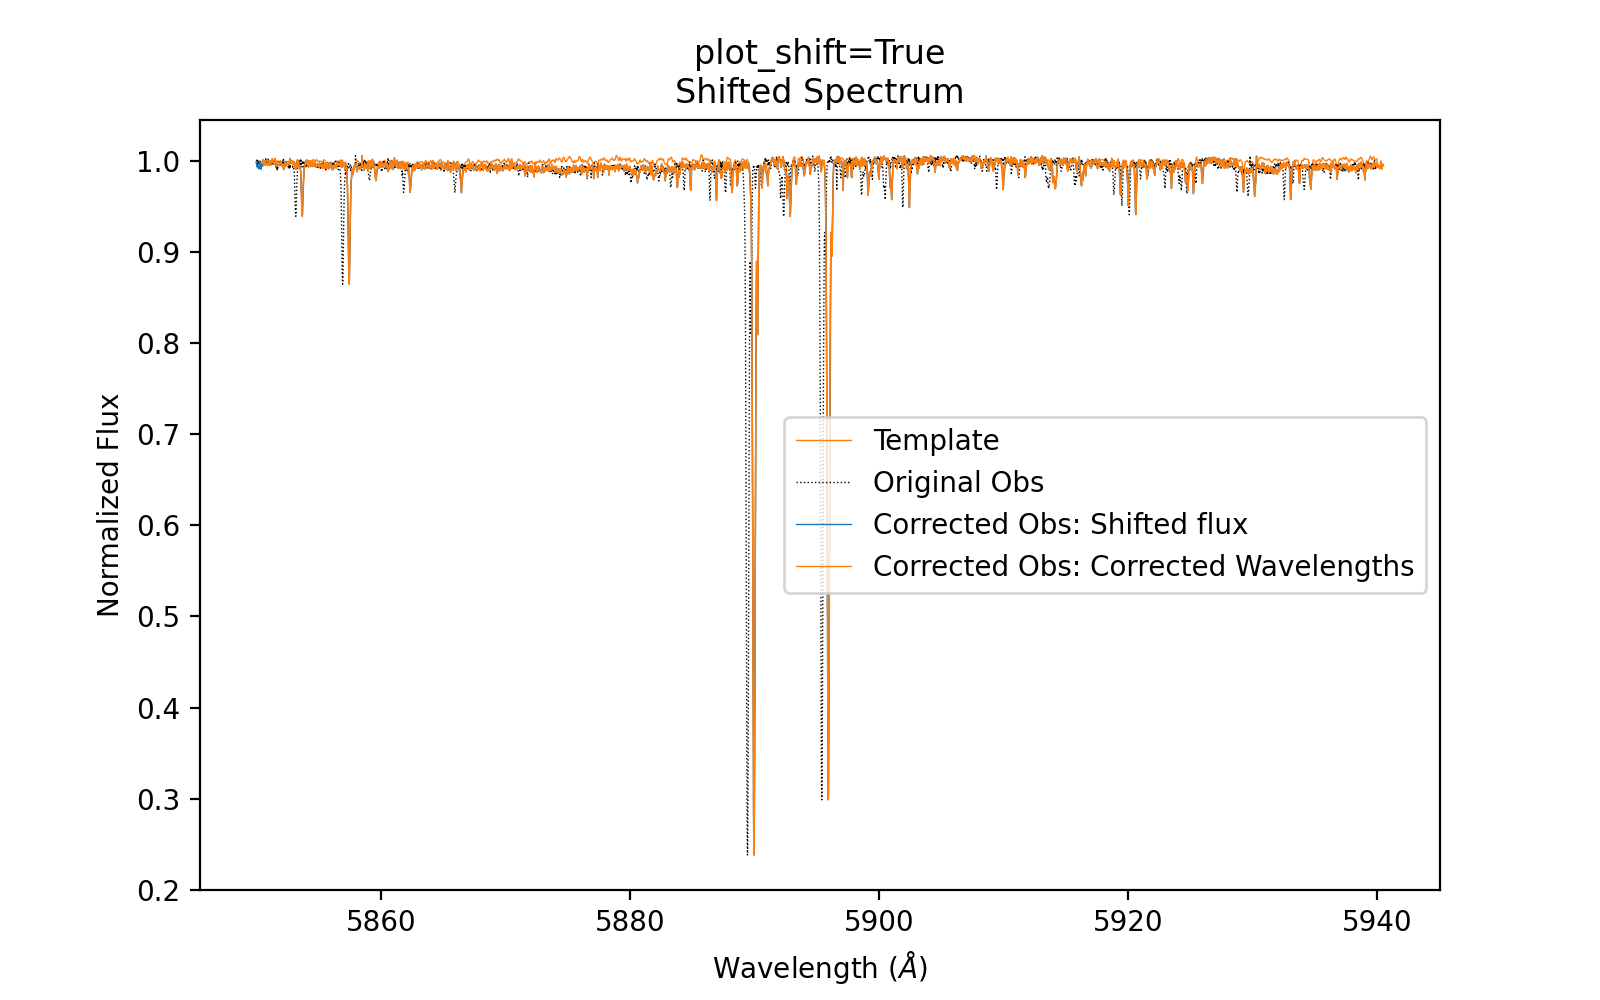

5174.996874975507


<IPython.core.display.Javascript object>


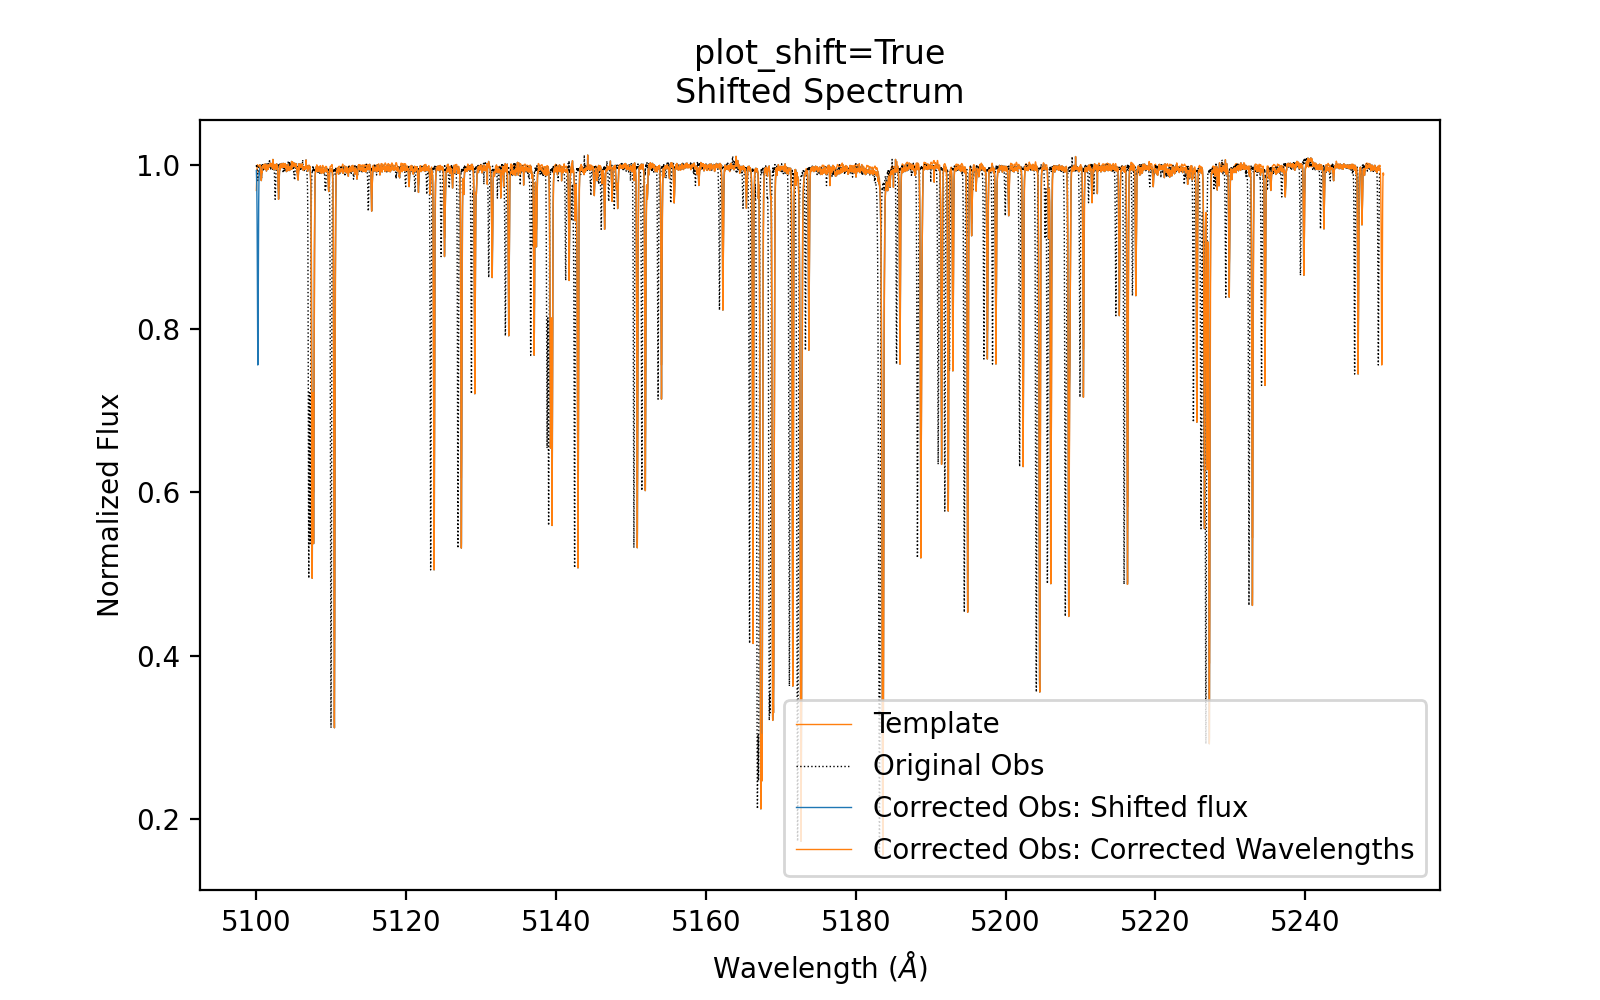

Velocity correction from Ha lines:  27.053129834393573
Velocity correction from Hb lines:  27.21065908122926
Velocity correction from Na lines:  26.563182190654953
Velocity correction from Mg lines:  26.472528182404684
Mean radial velocity: 26.82 $\pm$ 0.31


<IPython.core.display.Javascript object>


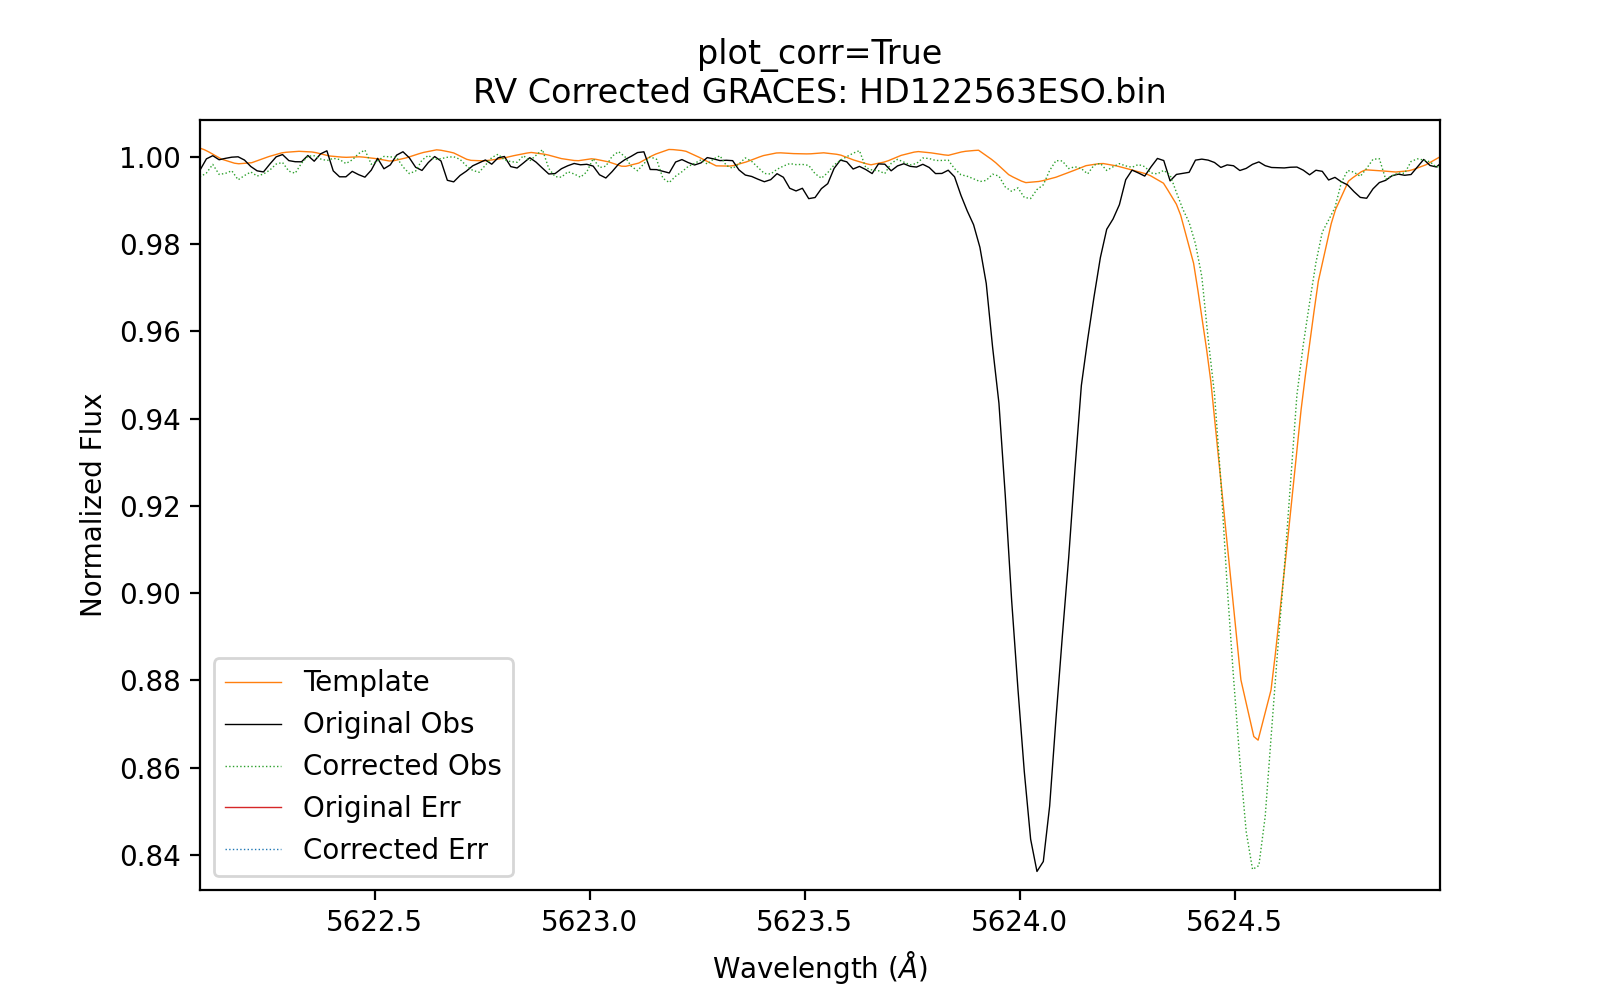

Saving radial velocity corrected spectrum to ../Data/GHOSTData/HD122563ESO.rv.bin
Saving radial velocity to ../Data/GHOSTData/HD122563ESO.txt


In [14]:
sa.rvcor(spec, 
         saveDir,
         template_spec, 
         template_path, 
          spec,
          rv_elems = ['Ha', 'Hb', 'Na', 'Mg'],
          manual_rv = None,
          save_out_spec = True,
          out_path = saveDir,
          plot_synth = True,
          plot_obs = True,
          plot_regions = True,
          plot_shift = True,
          plot_corr = True,
          print_spec_info = False,
          print_info = True,
          save_rv_info = True,
          rv_save_name = saveName,
          print_corr_spec_info = False,
          save_plot = False,
          save_plot_path = '',
          pause = False,)

### Save as .xy spectra
Create some ascii xy spectra (wavelength flux) for MOOG

In [17]:
saveDir

'../Data/GHOSTData/'

In [16]:
#  ---- Create a place for the final spectra
final_path = '../Data/final_spectra/' 

#  ---- Save as .xy file
sa.bin2xy_v2( spec[:-4] , saveDir, final_path, xytype = 'MOOG')

Saving .xy file to ../Data/final_spectra/HD122563ESO.xy


# Optional: Apply a heliocentric or barycentric correction to the radial velocity

This will not change the final spectrum and thus is optional.  However, it may be useful for comparing your final radial velocity to values in the literature


In [40]:
hdul = fits.open('/arc5/home/jglover/Data/GHOSTData/HD122563_hr_1x1_b60r10s1_20220630_1x1_blue1_formattedOutput.fits')

print(hdul[0].header['DATE-OBS'])
print(hdul[0].header['UTSTART'], hdul[0].header['UTEND'])

2022-07-01
00:18:27 00:19:27


In [32]:
rv = float(open(saveDir+spec[:-4]+'.txt').read().split()[6])
rverr = float(open(saveDir+spec[:-4]+'.txt').read().split()[7])

print('The original rv is {:.4} +/- {:.4f} km/s'.format(rv, rverr))

The original rv is -0.8021 +/- 0.0000 km/s


In [43]:
corrected_rv = cu.rvCoordinateCorrections(rv, telescope='gemini_south', isot_time='2022-07-01T00:18:95', objLoc_CDS='14 02 31.846 +09 41 9.94', kind='barycentric' )

# Scale the original rv error to the new rv value 
percent_err = rverr / rv
corrected_rverr = abs(corrected_rv * percent_err)

print('The corrected rv is {:.4} +/- {:.4f} km/s'.format(corrected_rv, corrected_rverr))

The corrected rv is -27.14 +/- 0.0007 km/s
